In [1]:
import numpy as np
import pandas as pd

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))


/kaggle/input/favorita-grocery-sales-forecasting/test.csv
/kaggle/input/favorita-grocery-sales-forecasting/stores.csv
/kaggle/input/favorita-grocery-sales-forecasting/train.csv
/kaggle/input/favorita-grocery-sales-forecasting/sample_submission.csv
/kaggle/input/favorita-grocery-sales-forecasting/items.csv
/kaggle/input/favorita-grocery-sales-forecasting/transactions.csv
/kaggle/input/favorita-grocery-sales-forecasting/holidays_events.csv
/kaggle/input/favorita-grocery-sales-forecasting/oil.csv


# Importing all required libraries

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
from sklearn.preprocessing import LabelEncoder,minmax_scale,PolynomialFeatures,StandardScaler,Normalizer
from sklearn.model_selection import KFold,GridSearchCV,train_test_split
import matplotlib.pyplot as plt
from scipy.stats import itemfreq
import seaborn as sns
from sklearn import linear_model
from sklearn.model_selection import cross_val_score
from sklearn.linear_model import Lasso
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression, Ridge, LassoCV, ElasticNetCV
from sklearn.metrics import mean_squared_error, make_scorer
#from sklearn.model_selection import train_test_split
%matplotlib inline
import datetime
from datetime import date, timedelta
from sklearn.tree import DecisionTreeRegressor
from sklearn.metrics import r2_score
from sklearn.metrics import mean_squared_error
from sklearn.ensemble import ExtraTreesRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import GradientBoostingRegressor
from xgboost import XGBRegressor
import sys

# Data Loading

In [3]:
#Loading the data
dtypes = {'store_nbr': np.dtype('int64'),
          'item_nbr': np.dtype('int64'),
          'unit_sales': np.dtype('float64'),
          'onpromotion': np.dtype('O')}

Sales = pd.read_csv('/kaggle/input/favorita-grocery-sales-forecasting/train.csv',dtype=dtypes)
test = pd.read_csv('/kaggle/input/favorita-grocery-sales-forecasting/test.csv', dtype=dtypes)
stores = pd.read_csv('/kaggle/input/favorita-grocery-sales-forecasting/stores.csv')
items = pd.read_csv('/kaggle/input/favorita-grocery-sales-forecasting/items.csv')
trans = pd.read_csv('/kaggle/input/favorita-grocery-sales-forecasting/transactions.csv')
#oil = pd.read_csv('../input/oil.csv') #we upload this database later
holidays = pd.read_csv('/kaggle/input/favorita-grocery-sales-forecasting/holidays_events.csv')

In [4]:
#sampling the data, since the data is too huge to carry put any operations
date_mask = (Sales['date'] >= '2016-07-15') & (Sales['date'] <= '2016-08-15')

Salesdf = Sales[date_mask]
#Print the size
len(Salesdf)

3117887

# Anomaly Detection

In [5]:
#Load the data
oil = pd.read_csv('/kaggle/input/favorita-grocery-sales-forecasting/oil.csv')

#add missing date
min_oil_date = min(Salesdf.date)
max_oil_date = max(Salesdf.date)
calendar = []

d1 = datetime.datetime.strptime(min_oil_date, '%Y-%m-%d')  # start date
d2 = datetime.datetime.strptime(max_oil_date, '%Y-%m-%d')  # end date


delta = d2 - d1         # timedelta


for i in range(delta.days + 1):
    calendar.append(datetime.date.strftime(d1 + timedelta(days=i), '%Y-%m-%d'))

calendar = pd.DataFrame({'date':calendar})

oil = calendar.merge(oil, left_on='date', right_on='date', how='left')

In [6]:
oil.head(5)

,date,dcoilwtico
0,2016-07-15,45.93
1,2016-07-16,NaN
2,2016-07-17,NaN
3,2016-07-18,45.23
4,2016-07-19,44.64


# Data Preparation and Cleaning

In [7]:
#Check how many NA
print(oil.isnull().sum(), '\n')

#Type
print('Type : ', '\n', oil.dtypes)



date           0
dcoilwtico    10
dtype: int64 

Type :  
 date           object
dcoilwtico    float64
dtype: object


# Analyzing Impact of Oil on the sales of other products

Adding values to NaN attributes using boundary method

In [8]:
#Check index to apply the formula
na_index_oil = oil[oil['dcoilwtico'].isnull() == True].index.values

#Define the index to use to apply the formala
na_index_oil_plus = na_index_oil.copy()
na_index_oil_minus = np.maximum(0, na_index_oil-1) # subtracting 1 from each indexes

for i in range(len(na_index_oil)):
    k = 1
    while (na_index_oil[min(i+k,len(na_index_oil)-1)] == na_index_oil[i]+k):
        k += 1
    na_index_oil_plus[i] = min(len(oil)-1, na_index_oil_plus[i] + k )

#Apply the formula

for i in range(len(na_index_oil)):
    if (na_index_oil[i] == 0):
        oil.loc[na_index_oil[i], 'dcoilwtico'] = oil.loc[na_index_oil_plus[i], 'dcoilwtico']
    elif (na_index_oil[i] == len(oil)-1):
        oil.loc[na_index_oil[i], 'dcoilwtico'] = oil.loc[na_index_oil_minus[i], 'dcoilwtico']
    else:
        oil.loc[na_index_oil[i], 'dcoilwtico'] = (oil.loc[na_index_oil_plus[i], 'dcoilwtico'] + oil.loc[na_index_oil_minus[i], 'dcoilwtico'])/ 2
print(oil.isnull().sum())
oil.head(5)

date          0
dcoilwtico    0
dtype: int64


,date,dcoilwtico
0,2016-07-15,45.930
1,2016-07-16,45.580
2,2016-07-17,45.405
3,2016-07-18,45.230
4,2016-07-19,44.640


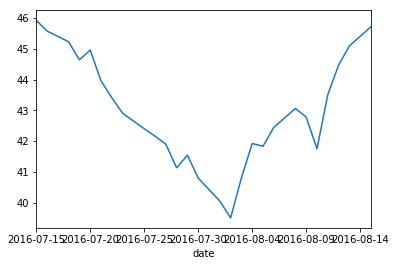

In [9]:
#Plot the oil values
oil_plot = oil['dcoilwtico'].copy()
oil_plot.index = oil['date'].copy()
oil_plot.plot()
#oil_plot.set_xticklabels([])
plt.show()

# Data Blending

In [10]:
Salesdf.info()
Salesdf = Salesdf.drop('id', axis = 1)
Salesdf = Salesdf.merge(stores, left_on='store_nbr', right_on='store_nbr', how='left')
Salesdf = Salesdf.merge(items, left_on='item_nbr', right_on='item_nbr', how='left')
Salesdf = Salesdf.merge(holidays, left_on='date', right_on='date', how='left')
Salesdf = Salesdf.merge(oil, left_on='date', right_on='date', how='left')
Salesdf = Salesdf.drop(['description', 'state', 'locale_name', 'class'], axis = 1)

<class 'pandas.core.frame.DataFrame'>
Int64Index: 3117887 entries, 85020772 to 88138658
Data columns (total 6 columns):
id             int64
date           object
store_nbr      int64
item_nbr       int64
unit_sales     float64
onpromotion    object
dtypes: float64(1), int64(3), object(2)
memory usage: 166.5+ MB


In [11]:
Salesdf.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 3218342 entries, 0 to 3218341
Data columns (total 14 columns):
date           object
store_nbr      int64
item_nbr       int64
unit_sales     float64
onpromotion    object
city           object
type_x         object
cluster        int64
family         object
perishable     int64
type_y         object
locale         object
transferred    object
dcoilwtico     float64
dtypes: float64(2), int64(4), object(8)
memory usage: 368.3+ MB


In [12]:
Salesdf.isnull().sum().sort_values(ascending=False)

transferred    2434721
locale         2434721
type_y         2434721
dcoilwtico           0
perishable           0
family               0
cluster              0
type_x               0
city                 0
onpromotion          0
unit_sales           0
item_nbr             0
store_nbr            0
date                 0
dtype: int64

In [13]:
#Shape
print('Shape : ', Salesdf.shape, '\n')

#Type
print('Type : ', '\n', Salesdf.dtypes)

#Summary
Salesdf.describe()

Shape :  (3218342, 14) 

Type :  
 date            object
store_nbr        int64
item_nbr         int64
unit_sales     float64
onpromotion     object
city            object
type_x          object
cluster          int64
family          object
perishable       int64
type_y          object
locale          object
transferred     object
dcoilwtico     float64
dtype: object


,store_nbr,item_nbr,unit_sales,cluster,perishable,dcoilwtico
count,3.218342e+06,3.218342e+06,3.218342e+06,3.218342e+06,3.218342e+06,3.218342e+06
mean,2.767294e+01,1.100111e+06,7.592344e+00,8.643655e+00,2.588240e-01,4.298099e+01
std,1.614841e+01,5.488708e+05,1.692901e+01,4.609769e+00,4.379888e-01,1.783225e+00
min,1.000000e+00,9.919700e+04,-1.750000e+02,1.000000e+00,0.000000e+00,3.950000e+01
25%,1.300000e+01,6.557490e+05,2.000000e+00,5.000000e+00,0.000000e+00,4.183000e+01
50%,2.800000e+01,1.146783e+06,4.000000e+00,9.000000e+00,0.000000e+00,4.275250e+01
75%,4.300000e+01,1.464002e+06,8.000000e+00,1.300000e+01,1.000000e+00,4.464000e+01
max,5.400000e+01,2.037487e+06,5.065200e+03,1.700000e+01,1.000000e+00,4.593000e+01


In [14]:
#10 random lines
Salesdf.sample(10)

,date,store_nbr,item_nbr,unit_sales,onpromotion,city,type_x,cluster,family,perishable,type_y,locale,transferred,dcoilwtico
584107,2016-07-20,53,1391548,2.000,False,Manta,D,13,GROCERY I,0,NaN,NaN,NaN,44.96
1959003,2016-08-03,3,318932,6.000,False,Quito,D,8,DELI,1,NaN,NaN,NaN,40.80
646847,2016-07-21,38,1908028,7.000,False,Loja,D,4,PRODUCE,1,NaN,NaN,NaN,43.96
2085729,2016-08-04,18,1473509,1.827,False,Quito,B,16,PRODUCE,1,NaN,NaN,NaN,41.92
2853573,2016-08-12,14,1621528,5.000,False,Riobamba,C,7,PRODUCE,1,Transfer,National,False,44.47
31644,2016-07-15,18,1390352,1.000,False,Quito,B,16,GROCERY I,0,NaN,NaN,NaN,45.93
2908990,2016-08-12,46,1457217,15.000,False,Quito,A,14,HOME CARE,0,Transfer,National,False,44.47
1842070,2016-08-01,48,716958,1.000,False,Quito,A,14,BEAUTY,0,NaN,NaN,NaN,40.05
2540937,2016-08-08,50,1501559,4.000,False,Ambato,A,14,PRODUCE,1,NaN,NaN,NaN,43.06
1909727,2016-08-02,31,1105212,49.000,False,Babahoyo,B,10,GROCERY I,0,NaN,NaN,NaN,39.50


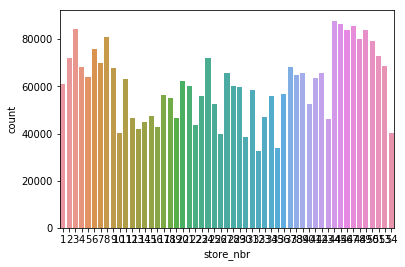

In [15]:
sns.countplot(x='store_nbr', data=Salesdf);

# The the above plot shows the number of stores according to each store type.

In [16]:
Salesdf.item_nbr.unique

<bound method Series.unique of 0           103665
1           105574
2           105575
3           105577
4           105693
            ...   
3218337    2026893
3218338    2026945
3218339    2026983
3218340    2027090
3218341    2027203
Name: item_nbr, Length: 3218342, dtype: int64>

In [17]:
x=itemfreq(Salesdf.item_nbr)
x=x[x[:,1].argsort()[::-1]]
x

/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:1: DeprecationWarning: `itemfreq` is deprecated!
`itemfreq` is deprecated and will be removed in a future version. Use instead `np.unique(..., return_counts=True)`
  """Entry point for launching an IPython kernel.


array([[ 314384,    1748],
       [ 364606,    1748],
       [1463810,    1746],
       ...,
       [1575252,       1],
       [ 579759,       1],
       [ 638327,       1]])

In [18]:
x[:,0][0:10]

array([ 314384,  364606, 1463810,  502331,  222879,  265559,  323013,
       1157564,  414353, 1958216])

In [19]:
s=Salesdf.item_nbr.as_matrix()
s

/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:1: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  """Entry point for launching an IPython kernel.


array([ 103665,  105574,  105575, ..., 2026983, 2027090, 2027203])

In [20]:
t=s.reshape(s.shape[0],1)
t

array([[ 103665],
       [ 105574],
       [ 105575],
       ...,
       [2026983],
       [2027090],
       [2027203]])

In [21]:
t1=np.where(t==x)
t1

/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:1: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  """Entry point for launching an IPython kernel.


(array([], dtype=int64),)

# Product Purchase Trend
### N most purchased products

In [22]:
def N_most_labels(data, variable , N , all='TRUE'):
    labels_freq_pd = itemfreq(data[variable])
    labels_freq_pd = labels_freq_pd[labels_freq_pd[:, 1].argsort()[::-1]] #[::-1] ==> to sort in descending order
    
    if all == 'FALSE':
        main_labels = labels_freq_pd[:,0][0:N]
    else: 
        main_labels = labels_freq_pd[:,0][:]
        
    labels_raw_np = data[variable].as_matrix() #transform in numpy
    labels_raw_np = labels_raw_np.reshape(labels_raw_np.shape[0],1)

    labels_filtered_index = np.where(labels_raw_np == main_labels)
    
    return labels_freq_pd, labels_filtered_index

label_freq, labels_filtered_index = N_most_labels(data = Salesdf, variable = "item_nbr", N = 20, all='FALSE')
print("labels_filtered_index[0].shape = ", labels_filtered_index[0].shape)

Salesdf_filtered = Salesdf.loc[labels_filtered_index[0],:]

/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:2: DeprecationWarning: `itemfreq` is deprecated!
`itemfreq` is deprecated and will be removed in a future version. Use instead `np.unique(..., return_counts=True)`
  
/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:10: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  # Remove the CWD from sys.path while we load stuff.


labels_filtered_index[0].shape =  (34678,)


#### The number of most purchased products gives us the idea of looking for the sales for those products.

In [23]:
label_freq[0:10]

array([[ 314384,    1748],
       [ 364606,    1748],
       [1463810,    1746],
       [ 502331,    1744],
       [ 222879,    1743],
       [ 265559,    1742],
       [ 323013,    1740],
       [1157564,    1738],
       [ 414353,    1737],
       [1958216,    1734]])

In [24]:
Salesdf_filtered

,date,store_nbr,item_nbr,unit_sales,onpromotion,city,type_x,cluster,family,perishable,type_y,locale,transferred,dcoilwtico
119,2016-07-15,1,222879,9.0,False,Quito,D,13,GROCERY I,0,NaN,NaN,NaN,45.93
142,2016-07-15,1,261052,6.0,True,Quito,D,13,GROCERY I,0,NaN,NaN,NaN,45.93
156,2016-07-15,1,265559,29.0,False,Quito,D,13,GROCERY I,0,NaN,NaN,NaN,45.93
170,2016-07-15,1,273528,9.0,False,Quito,D,13,PERSONAL CARE,0,NaN,NaN,NaN,45.93
193,2016-07-15,1,314384,25.0,False,Quito,D,13,GROCERY I,0,NaN,NaN,NaN,45.93
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3218052,2016-08-15,54,1463810,29.0,False,El Carmen,C,3,BEVERAGES,0,Holiday,Local,False,45.72
3218053,2016-08-15,54,1463814,5.0,False,El Carmen,C,3,BEVERAGES,0,Holiday,Local,False,45.72
3218058,2016-08-15,54,1463855,9.0,False,El Carmen,C,3,BEVERAGES,0,Holiday,Local,False,45.72
3218060,2016-08-15,54,1463860,9.0,False,El Carmen,C,3,BEVERAGES,0,Holiday,Local,False,45.72


In [25]:
print('Shape : ', Salesdf_filtered.shape, '\n')

#Type
print('Type : ', '\n', Salesdf_filtered.dtypes)

Shape :  (34678, 14) 

Type :  
 date            object
store_nbr        int64
item_nbr         int64
unit_sales     float64
onpromotion     object
city            object
type_x          object
cluster          int64
family          object
perishable       int64
type_y          object
locale          object
transferred     object
dcoilwtico     float64
dtype: object


In [26]:
#Fill in cells if there is no holiday by the value : "no_holyday"
na_index_Salesdf = Salesdf_filtered[Salesdf_filtered['type_y'].isnull() == True].index.values
print("Size of na_index_Salesdf : ", len(na_index_Salesdf), '\n')

Salesdf_filtered.loc[Salesdf_filtered['type_y'].isnull(), 'type_y'] = "no_holyday"
Salesdf_filtered.loc[Salesdf_filtered['locale'].isnull(), 'locale'] = "no_locale"
Salesdf_filtered.loc[Salesdf_filtered['transferred'].isnull(), 'transferred'] = "no_holyday"
    
#check is there is NA
Salesdf_filtered.isnull().sum()

Size of na_index_Salesdf :  26267 



date           0
store_nbr      0
item_nbr       0
unit_sales     0
onpromotion    0
city           0
type_x         0
cluster        0
family         0
perishable     0
type_y         0
locale         0
transferred    0
dcoilwtico     0
dtype: int64

In [27]:
strain_plots = Salesdf_filtered.sample(frac=0.01,replace=True)

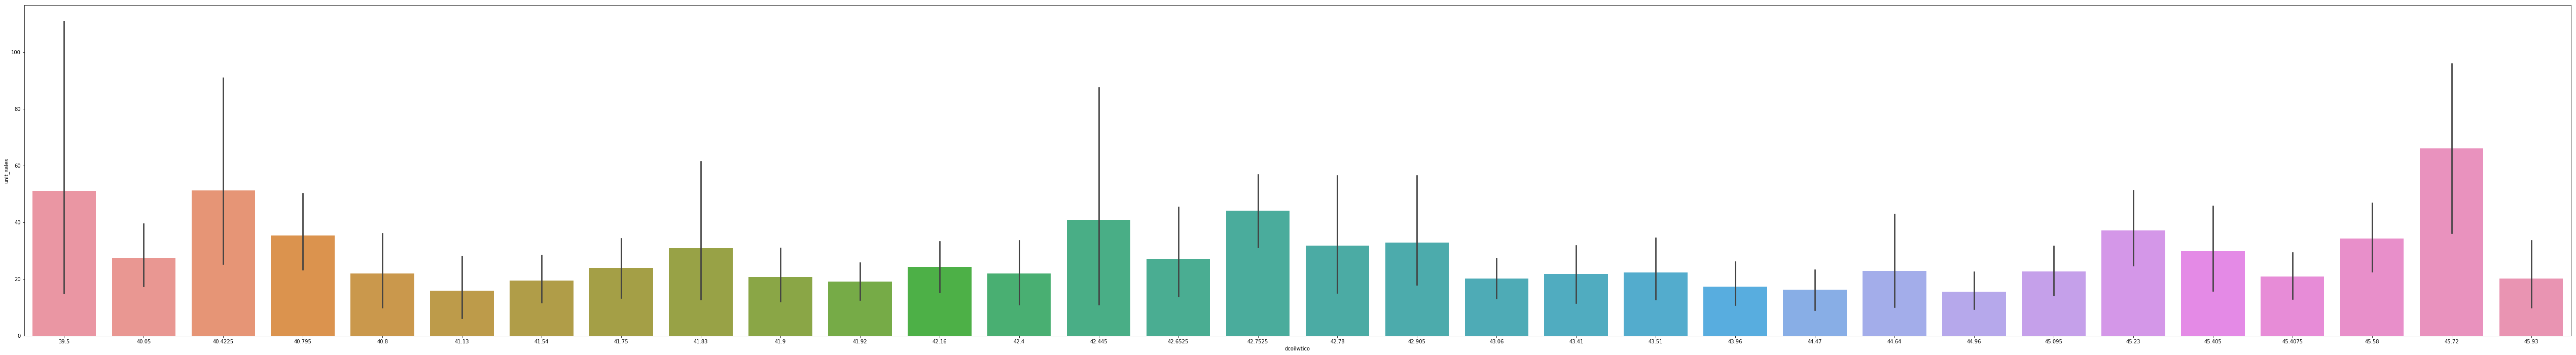

In [28]:
fig, (axis1) = plt.subplots(1,1,figsize=(90,12))
sns.barplot(x='dcoilwtico', y='unit_sales', data=strain_plots, ax=axis1)


## The above plot shows unit_sales for different oil prices.
#### We can see that small change in oil price varies unit_sales drastically, which leads to Variance_Inflation_Factor which we will see further.

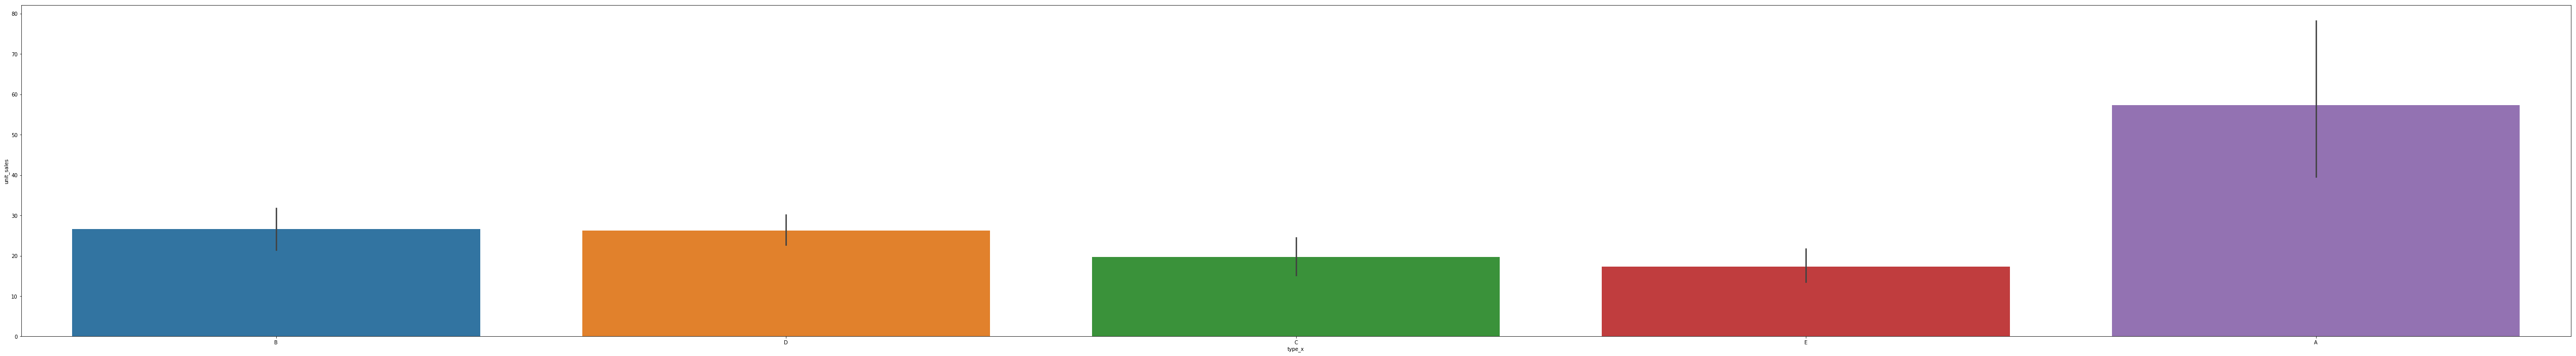

In [29]:
fig, (axis1) = plt.subplots(1,1,figsize=(90,12))
sns.barplot(x='type_x', y='unit_sales', data=strain_plots, ax=axis1)

## The above plot shows unit_sales for different store types.

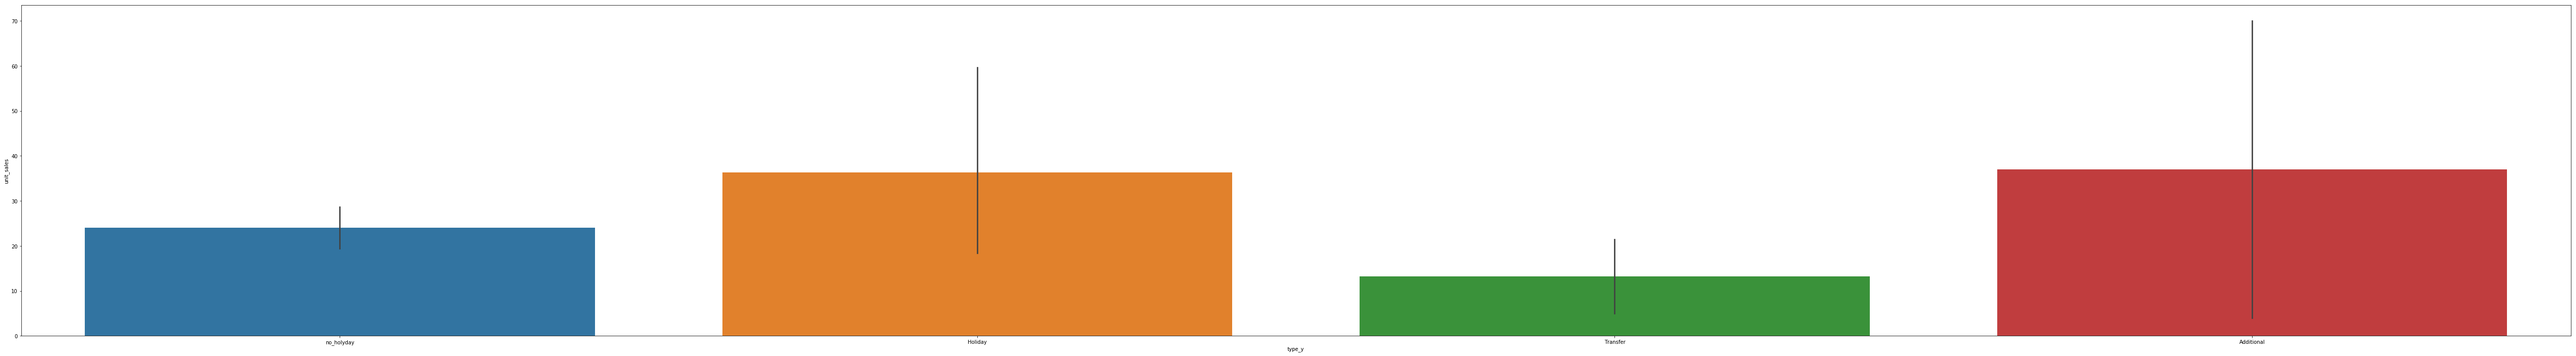

In [30]:
fig, (axis1) = plt.subplots(1,1,figsize=(90,12))
sns.barplot(x='type_y', y='unit_sales', data=strain_plots[0:100], ax=axis1)

## The above plot shows unit_sales for different Holiday types.

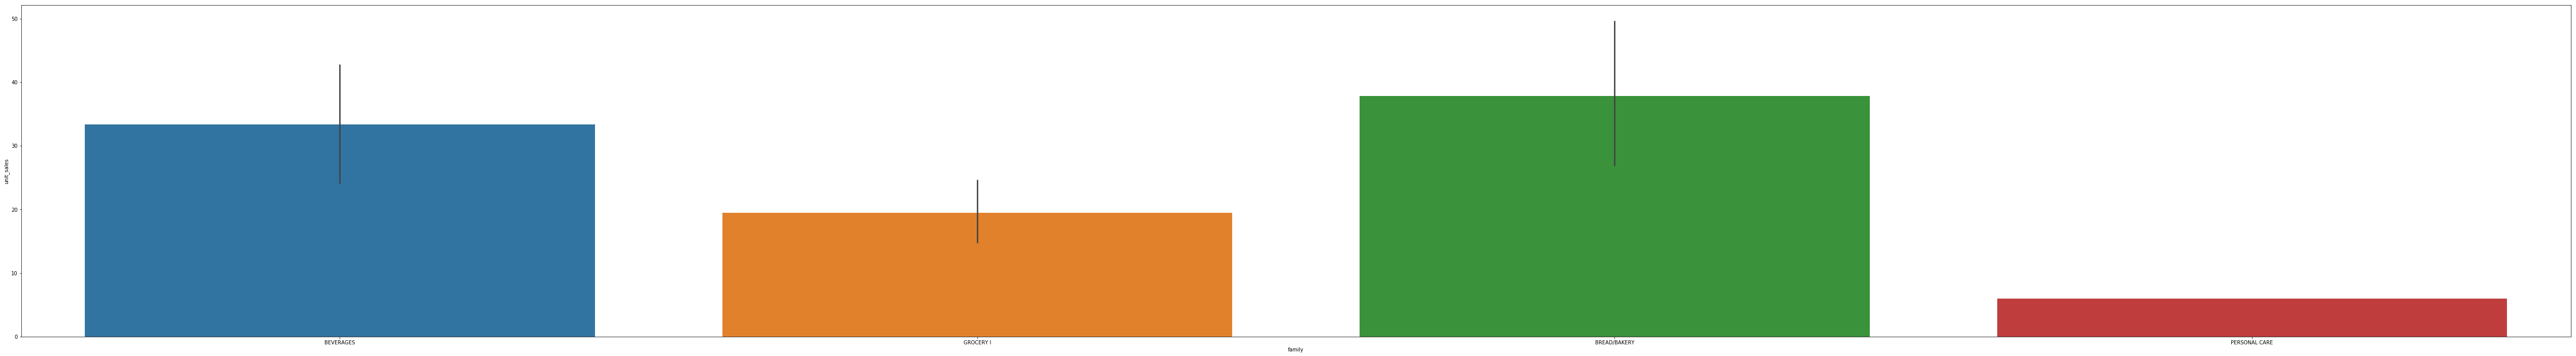

In [31]:
fig, (axis1) = plt.subplots(1,1,figsize=(90,12))
sns.barplot(x='family', y='unit_sales', data=strain_plots[0:100], ax=axis1)

## The above plot shows unit_sales for different family of products.

In [32]:
def get_month_year(df):
    df['month'] = df.date.apply(lambda x: x.split('-')[1])
    df['year'] = df.date.apply(lambda x: x.split('-')[0])
    
    return df

get_month_year(Salesdf_filtered);

In [33]:
Salesdf_filtered['date'] = pd.to_datetime(Salesdf_filtered['date'])
Salesdf_filtered['day'] = Salesdf_filtered['date'].dt.weekday_name
Salesdf_filtered = Salesdf_filtered.drop('date', axis=1)

In [34]:
Salesdf_filtered.sample(10)

,store_nbr,item_nbr,unit_sales,onpromotion,city,type_x,cluster,family,perishable,type_y,locale,transferred,dcoilwtico,month,year,day
2370157,11,1463855,26.0,False,Cayambe,B,6,BEVERAGES,0,no_holyday,no_locale,no_holyday,42.7525,08,2016,Sunday
1421332,42,273528,4.0,False,Cuenca,D,2,PERSONAL CARE,0,no_holyday,no_locale,no_holyday,41.1300,07,2016,Thursday
2199651,30,265559,23.0,False,Guayaquil,C,3,GROCERY I,0,Holiday,Local,False,41.8300,08,2016,Friday
546865,34,364606,25.0,False,Guayaquil,B,6,GROCERY I,0,no_holyday,no_locale,no_holyday,44.9600,07,2016,Wednesday
1474956,17,273528,11.0,False,Quito,C,12,PERSONAL CARE,0,no_holyday,no_locale,no_holyday,41.5400,07,2016,Friday
1780825,15,1036689,4.0,False,Ibarra,C,15,GROCERY I,0,no_holyday,no_locale,no_holyday,40.0500,08,2016,Monday
1216036,28,222879,17.0,False,Guayaquil,E,10,GROCERY I,0,no_holyday,no_locale,no_holyday,42.1600,07,2016,Tuesday
1870043,8,261052,7.0,True,Quito,D,8,GROCERY I,0,no_holyday,no_locale,no_holyday,39.5000,08,2016,Tuesday
1492451,27,1958216,78.0,False,Daule,D,1,BEVERAGES,0,no_holyday,no_locale,no_holyday,41.5400,07,2016,Friday
2714439,44,1463810,122.0,False,Quito,A,5,BEVERAGES,0,Holiday,National,True,41.7500,08,2016,Wednesday


# Exploratory Data Analysis

In [35]:
strain = Salesdf.sample(frac=0.01,replace=True)
strain

,date,store_nbr,item_nbr,unit_sales,onpromotion,city,type_x,cluster,family,perishable,type_y,locale,transferred,dcoilwtico
1964983,2016-08-03,5,1473482,37.070,True,Santo Domingo,D,4,PRODUCE,1,NaN,NaN,NaN,40.8000
2996879,2016-08-13,42,364606,28.000,False,Cuenca,D,2,GROCERY I,0,NaN,NaN,NaN,45.0950
2791146,2016-08-11,35,414750,2.000,False,Playas,C,3,GROCERY I,0,NaN,NaN,NaN,43.5100
912037,2016-07-24,9,1965358,1.000,True,Quito,B,6,BEAUTY,0,Additional,Local,False,42.6525
3131859,2016-08-15,5,1333307,20.000,True,Santo Domingo,D,4,BREAD/BAKERY,1,Holiday,Local,False,45.7200
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
671020,2016-07-21,50,1084425,3.000,False,Ambato,A,14,BEVERAGES,0,NaN,NaN,NaN,43.9600
1693927,2016-07-31,25,1920072,1.000,True,Salinas,D,1,GROCERY I,0,NaN,NaN,NaN,40.4225
3144540,2016-08-15,11,1695935,1.305,False,Cayambe,B,6,PRODUCE,1,Holiday,Local,False,45.7200
908650,2016-07-24,9,368136,6.000,False,Quito,B,6,GROCERY I,0,Transfer,Local,False,42.6525


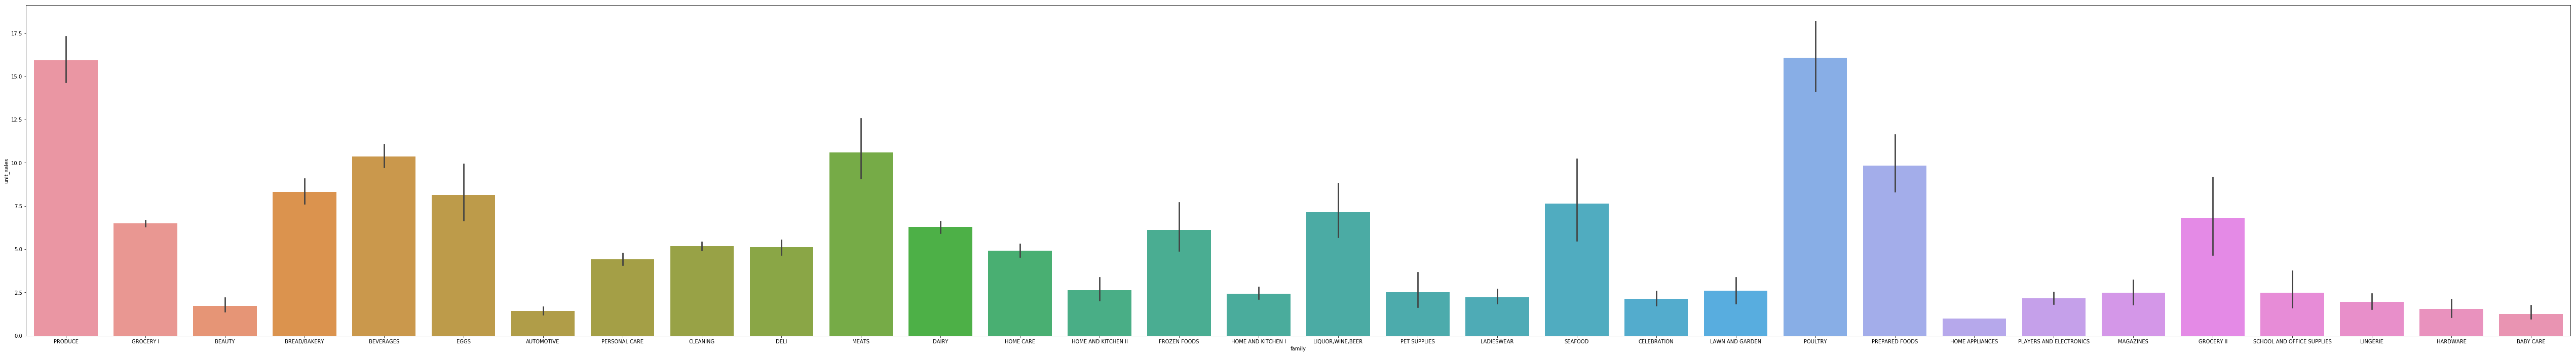

In [36]:
# Plotting Sales per Item Family
fig, (axis1) = plt.subplots(1,1,figsize=(90,12))
sns.barplot(x='family', y='unit_sales', data=strain, ax=axis1)

## The above plot shows the sales of products per Item family. The average unit_sales ranges somewhere between 0 to 20 with the maximum for the Food and Beverages item family.

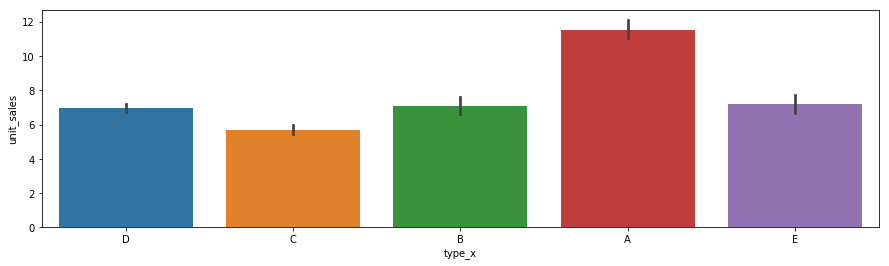

In [37]:
# Plotting Sales per Store Type
fig, (axis1) = plt.subplots(1,1,figsize=(15,4))
sns.barplot(x='type_x', y='unit_sales', data=strain, ax=axis1)

## The bar plot of Total Sales per store type shows that Store type A has the maximum sales over other store types.

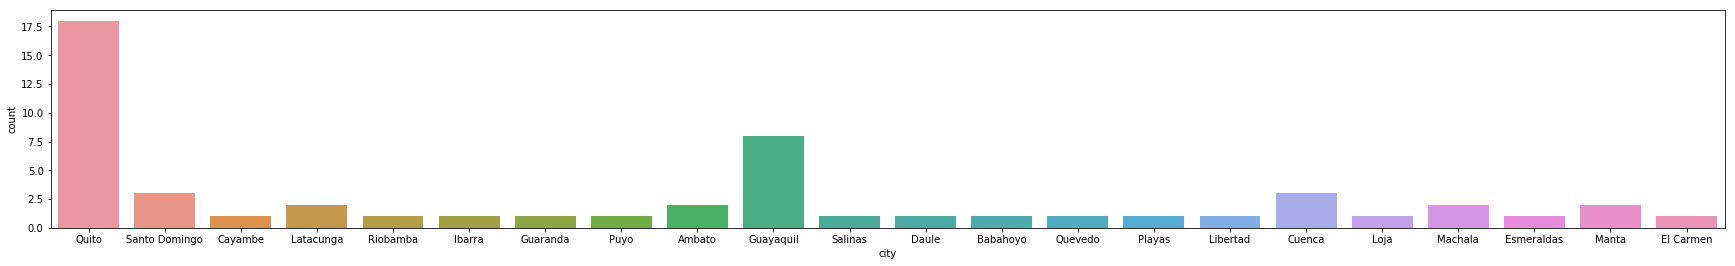

In [38]:
# Plotting Stores in Cities
fig, (axis1) = plt.subplots(1,1,figsize=(30,4))
sns.countplot(x=stores['city'], data=stores, ax=axis1)

## The City of Quito has the most number of Stores and the second being the city of Guayaquil.

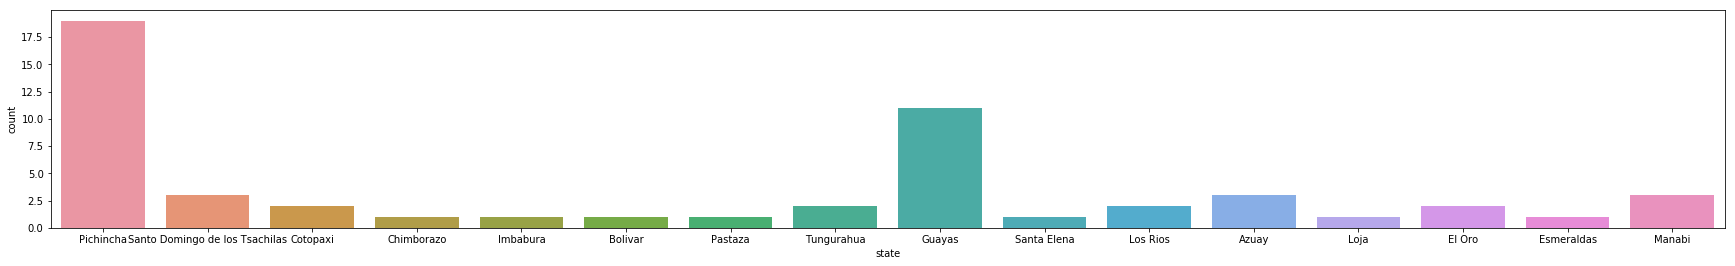

In [39]:
# Plotting Stores in States
fig, (axis1) = plt.subplots(1,1,figsize=(30,4))
sns.countplot(x=stores['state'], data=stores, ax=axis1)

## The States of Pichincha Santo and the state of Guayas has the most number of Stores.

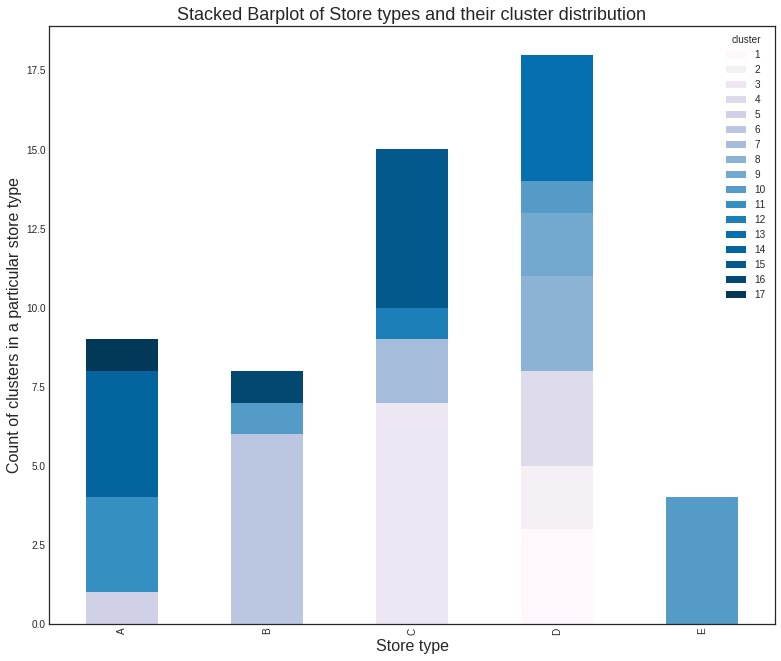

In [40]:
# Stacked Barplots of Types against clusters
plt.style.use('seaborn-white')
#plt.style.use('dark_background')
type_cluster = stores.groupby(['type','cluster']).size()
type_cluster.unstack().plot(kind='bar',stacked=True, colormap= 'PuBu', figsize=(13,11),  grid=False)
plt.title('Stacked Barplot of Store types and their cluster distribution', fontsize=18)
plt.ylabel('Count of clusters in a particular store type', fontsize=16)
plt.xlabel('Store type', fontsize=16)
plt.show()

# The above bar plot shows the cluster distribution across the store types.

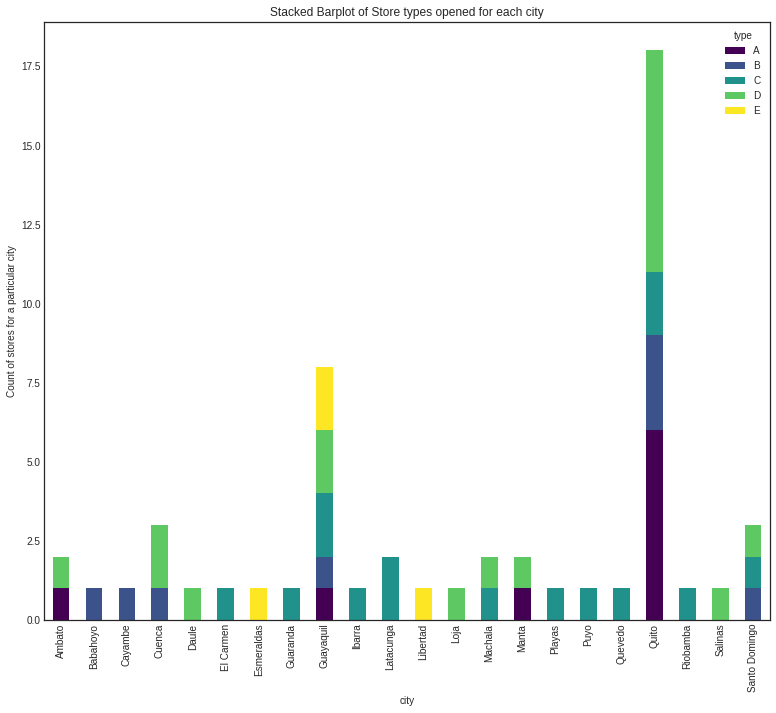

In [41]:
# Stacked barplot of types of stores across the different cities
plt.style.use('seaborn-white')
city_cluster = stores.groupby(['city','type']).store_nbr.size()
city_cluster.unstack().plot(kind='bar',stacked=True, colormap= 'viridis', figsize=(13,11),  grid=False)
plt.title('Stacked Barplot of Store types opened for each city')
plt.ylabel('Count of stores for a particular city')
plt.show()

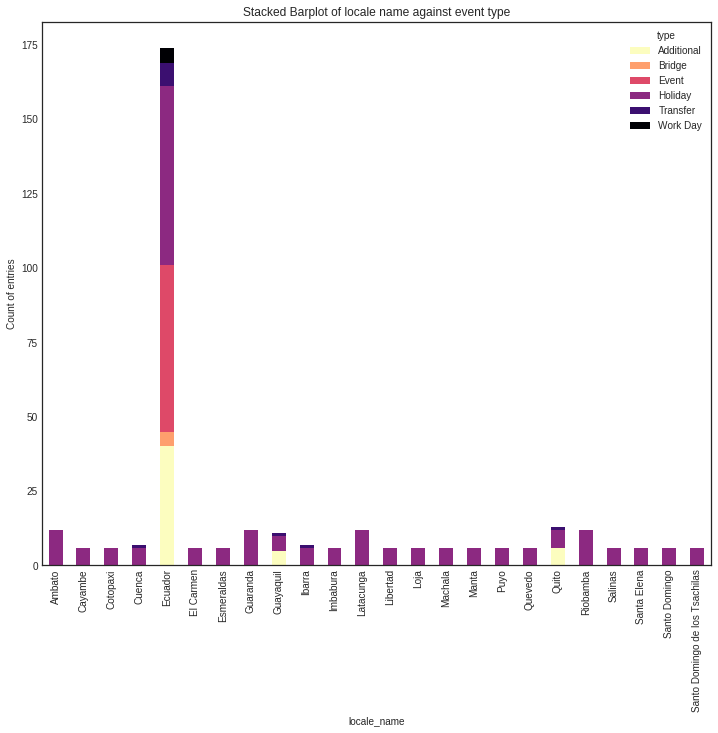

In [42]:
# Holiday Events data
plt.style.use('seaborn-white')
# plt.style.use('dark_background')
holiday_local_type = holidays.groupby(['locale_name', 'type']).size()
holiday_local_type.unstack().plot(kind='bar',stacked=True, colormap= 'magma_r', figsize=(12,10),  grid=False)
plt.title('Stacked Barplot of locale name against event type')
plt.ylabel('Count of entries')
plt.show()

# Data Transformation

## What is One Hot Encoding?
A one hot encoding is a representation of categorical variables as binary vectors. This first requires that the categorical values be mapped to integer values. Then, each integer value is represented as a binary vector that is all zero values except the index of the integer, which is marked with a 1.

# Why Use a One Hot Encoding?
A one hot encoding allows the representation of categorical data to be more expressive. Many machine learning algorithms cannot work with categorical data directly. The categories must be converted into numbers. This is required for both input and output variables that are categorical.

In [43]:
## One hot encoding using get_dummies on pandas dataframe.
dummy_variables = ['onpromotion','city','type_x','cluster','store_nbr','item_nbr',
                'family','perishable','type_y', 'locale', 'transferred', 'month', 'day']

for var in dummy_variables:
    dummy = pd.get_dummies(Salesdf_filtered[var], prefix = var, drop_first = False)
    Salesdf_filtered = pd.concat([Salesdf_filtered, dummy], axis = 1)

Salesdf_filtered = Salesdf_filtered.drop(dummy_variables, axis = 1)
Salesdf_filtered = Salesdf_filtered.drop(['year'], axis = 1)

In [44]:
Salesdf_filtered.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 34678 entries, 119 to 3218223
Columns: 146 entries, unit_sales to day_Wednesday
dtypes: float64(2), uint8(144)
memory usage: 5.6 MB


In [45]:
Salesdf_filtered.head()

,unit_sales,dcoilwtico,onpromotion_False,onpromotion_True,city_Ambato,city_Babahoyo,city_Cayambe,city_Cuenca,city_Daule,city_El Carmen,...,transferred_no_holyday,month_07,month_08,day_Friday,day_Monday,day_Saturday,day_Sunday,day_Thursday,day_Tuesday,day_Wednesday
119,9.0,45.93,1,0,0,0,0,0,0,0,...,1,1,0,1,0,0,0,0,0,0
142,6.0,45.93,0,1,0,0,0,0,0,0,...,1,1,0,1,0,0,0,0,0,0
156,29.0,45.93,1,0,0,0,0,0,0,0,...,1,1,0,1,0,0,0,0,0,0
170,9.0,45.93,1,0,0,0,0,0,0,0,...,1,1,0,1,0,0,0,0,0,0
193,25.0,45.93,1,0,0,0,0,0,0,0,...,1,1,0,1,0,0,0,0,0,0


In [46]:
#Re-scale
#We keep this value to re-scale the predicted unit_sales values in the following lines of code.
min_train, max_train = Salesdf_filtered['unit_sales'].min(), Salesdf_filtered['unit_sales'].max()

In [47]:
scalable_variables = ['unit_sales','dcoilwtico']

for var in scalable_variables:
    mini, maxi = Salesdf_filtered[var].min(), Salesdf_filtered[var].max()
    Salesdf_filtered.loc[:,var] = (Salesdf_filtered[var] - mini) / (maxi - mini)

In [48]:
print('Shape : ', Salesdf_filtered.shape)
Salesdf_filtered.sample(10)

Shape :  (34678, 146)


,unit_sales,dcoilwtico,onpromotion_False,onpromotion_True,city_Ambato,city_Babahoyo,city_Cayambe,city_Cuenca,city_Daule,city_El Carmen,...,transferred_no_holyday,month_07,month_08,day_Friday,day_Monday,day_Saturday,day_Sunday,day_Thursday,day_Tuesday,day_Wednesday
2596550,0.015094,0.510109,0,1,0,0,0,0,0,0,...,1,0,1,0,0,0,0,0,1,0
324833,0.041509,0.891135,1,0,0,0,0,0,0,0,...,1,1,0,0,1,0,0,0,0,0
447712,0.047170,0.799378,1,0,0,0,0,0,0,0,...,1,1,0,0,0,0,0,0,1,0
392238,0.090566,0.891135,1,0,0,0,0,0,0,0,...,1,1,0,0,1,0,0,0,0,0
1307584,0.011321,0.373250,0,1,0,0,0,0,1,0,...,1,1,0,0,0,0,0,0,0,1
1777879,0.018868,0.085537,1,0,0,0,0,0,0,0,...,1,0,1,0,1,0,0,0,0,0
325124,0.056604,0.891135,1,0,0,0,0,0,0,0,...,1,1,0,0,1,0,0,0,0,0
3176426,0.016981,0.967341,1,0,0,0,0,0,0,0,...,0,0,1,0,1,0,0,0,0,0
830206,0.067925,0.529549,1,0,0,0,0,0,0,0,...,0,1,0,0,0,1,0,0,0,0
2767651,0.024528,0.623639,0,1,0,0,0,0,0,0,...,1,0,1,0,0,0,0,1,0,0


In [49]:
Salesdf_filtered.isnull().sum()

unit_sales           0
dcoilwtico           0
onpromotion_False    0
onpromotion_True     0
city_Ambato          0
                    ..
day_Saturday         0
day_Sunday           0
day_Thursday         0
day_Tuesday          0
day_Wednesday        0
Length: 146, dtype: int64

In [50]:
#train database without unit_sales
Salesdf_filtered = Salesdf_filtered.reset_index(drop=True)  #we reset the index
y = Salesdf_filtered['unit_sales']
X = Salesdf_filtered.drop(['unit_sales'], axis = 1)

print('Shape X :', X.shape)
print('Shape y :', y.shape)

Shape X : (34678, 145)
Shape y : (34678,)


In [51]:
num_test = 0.20
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=num_test, random_state=15)
print('X_train shape :', X_train.shape)
print('y_train shape :', y_train.shape)
print('X_test shape :', X_test.shape)
print('y_test shape :', y_test.shape)

X_train shape : (27742, 145)
y_train shape : (27742,)
X_test shape : (6936, 145)
y_test shape : (6936,)


# Regression Model fitting techniques.
## Linear Regression
Linear Regression is a linear approach for modelling the relationship between a scalar dependent variable y and one or more explanatory variables (or independent variables) denoted X. The case of one explanatory variable is called simple linear regression. For more than one explanatory variable, the process is called multiple linear regression.

Linear regression models are often fitted using the least squares approach, but they may also be fitted in other ways, such as by minimizing the "lack of fit" in some other norm (as with least absolute deviations regression), or by minimizing a penalized version of the least squares cost function as in ridge regression (L2-norm penalty) and lasso (L1-norm penalty).

In [52]:
# Fit the linear model
model = linear_model.LinearRegression()
results = model.fit(X_train, y_train)
print(results)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)


In [53]:
# Print the coefficients
print (results.intercept_, results.coef_)

61921163176.23975 [-1.42839867e-02 -6.85476841e+10 -6.85476841e+10 -4.81219445e+10
 -9.31337114e+10 -1.31276542e+11 -2.11570209e+11  2.26966361e+10
 -1.42167941e+10 -5.94696916e+10  3.73748195e+10 -1.02045155e+11
  3.69603790e+10  1.11832001e+10 -7.40924538e+10 -4.01626249e+10
 -5.10848694e+10 -2.14161650e+10 -2.31544530e+10  2.14695941e+10
 -5.36977719e+10 -2.66036398e+10  2.13577625e+10 -1.34339079e+10
 -5.40834586e+10 -1.24426756e+11  4.66657904e+09  5.59520101e+10
  1.68048277e+10  2.39527758e+10 -6.09100219e+10  1.08349493e+11
 -6.08410360e+10 -2.49942896e+10  3.96031702e+10  1.92428164e+10
 -1.11127786e+11 -4.98406533e+10 -1.36519847e+10 -1.25808180e+10
  6.08613002e+10 -4.87659510e+10 -2.91864087e+10  4.28647940e+10
 -9.05921373e+10 -1.54893402e+10  6.24926497e+10 -2.13076836e+10
 -2.13076836e+10 -6.53438996e+08 -3.68421076e+10  1.98001612e+09
 -2.13076836e+10 -6.53438996e+08 -6.53438996e+08 -5.75986600e+10
  9.50862554e+08  4.70742419e+10 -3.68359773e+10 -3.68359773e+10
 -2.647

In [54]:
#Predicting X_test using our model
y_pred = results.predict(X_test)
print(y_pred)

[0.03691864 0.04779816 0.02523041 ... 0.04598236 0.01998901 0.04025269]


In [55]:
#Evaluating our model using different evaluation metrics
#1 #Explained variance regression score function
from sklearn.metrics import explained_variance_score, mean_squared_error, r2_score

#Best possible value is 1.0, lower value is worse (EVS)
print('Explained Variance Score =',explained_variance_score(y_test, y_pred, multioutput='uniform_average'), '/ 1.0')
print('R2 Score =', r2_score(y_test, y_pred), '/ 1.0') 
print('RMSE = ', mean_squared_error(y_test, y_pred), '/ 0.0')

Explained Variance Score = 0.4623867760957836 / 1.0
R2 Score = 0.46222305501705285 / 1.0
RMSE =  0.0017995053824982773 / 0.0


In [56]:
import statsmodels.regression.linear_model as sm

#import statsmodels.formula.api as sm
model = sm.OLS(endog=y_train, exog=X_train)
results = model.fit()
# Statsmodels gives R-like statistical output
results.summary()

# Here the Ordinalry Least Squares method has given us the r^2 value of 0.453 which is poor for model to be predicted on these variables.

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:             unit_sales   R-squared:                       0.453
Model:                            OLS   Adj. R-squared:                  0.451
Method:                 Least Squares   F-statistic:                     269.5
Date:                Fri, 25 Oct 2019   Prob (F-statistic):               0.00
Time:                        23:05:23   Log-Likelihood:                 47308.
No. Observations:               27742   AIC:                        -9.444e+04
Df Residuals:                   27656   BIC:                        -9.374e+04
Df Model:                          85                                         
Covariance Type:            nonrobust                                         
==========================================================================================
                             coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------------
dcoilwtico                -0.0143      0.001    -13.832      0.000      -0.016      -0.012
onpromotion_False          0.0016      0.001      2.949      0.003       0.001       0.003
onpromotion_True           0.0202      0.001     29.964      0.000       0.019       0.022
city_Ambato               -0.0074      0.001     -8.667      0.000      -0.009      -0.006
city_Babahoyo              0.0048      0.001      6.522      0.000       0.003       0.006
city_Cayambe               0.0027      0.001      2.945      0.003       0.001       0.004
city_Cuenca                0.0041      0.001      5.341      0.000       0.003       0.006
city_Daule                 0.0040      0.001      4.711      0.000       0.002       0.006
city_El Carmen             0.0020      0.001      2.153      0.031       0.000       0.004
city_Esmeraldas           -0.0055      0.001     -6.134      0.000      -0.007      -0.004
city_Guaranda              0.0032      0.001      3.625      0.000       0.001       0.005
city_Guayaquil            -0.0101      0.001    -15.442      0.000      -0.011      -0.009
city_Ibarra               -0.0018      0.001     -2.062      0.039      -0.004   -8.93e-05
city_Latacunga             0.0013      0.001      1.590      0.112      -0.000       0.003
city_Libertad             -0.0055      0.001     -6.182      0.000      -0.007      -0.004
city_Loja                  0.0072      0.001      8.410      0.000       0.006       0.009
city_Machala               0.0187      0.001     21.299      0.000       0.017       0.020
city_Manta                 0.0161      0.001     18.284      0.000       0.014       0.018
city_Playas               -0.0108      0.001    -11.720      0.000      -0.013      -0.009
city_Puyo                 -0.0029      0.001     -3.842      0.000      -0.004      -0.001
city_Quevedo               0.0018      0.001      2.046      0.041    7.76e-05       0.004
city_Quito                 0.0091      0.001     16.336      0.000       0.008       0.010
city_Riobamba             -0.0020      0.001     -2.600      0.009      -0.003      -0.000
city_Salinas              -0.0099      0.001    -11.563      0.000      -0.012      -0.008
city_Santo Domingo         0.0026      0.001      3.155      0.002       0.001       0.004
type_x_A                   0.0308      0.000     62.268      0.000       0.030       0.032
type_x_B                  -0.0016      0.000     -3.234      0.001      -0.003      -0.001
type_x_C                  -0.0111      0.000    -27.134      0.000      -0.012      -0.010
type_x_D                  -0.0052      0.000    -11.351      0.000      -0.006      -0.004
type_x_E                   0.0089      0.001     13.175      0.000       0.008       0.010
cluster_1                  0.0055      0.001      7.539      0.000       0.004  

## The Linear regression model gives a low R- square value of 0.453

## Checking for VIF for eliminating multicollinearity and overfitting

In [57]:
#Implementing VIF (Variance Inflation Factor) to check whether the selected independent variables are correct for prediction 
# or not. Also, 'item_nbr', 'perishable' and 'dcoilwtico' had very close levels of co-relation with price which makes us to investigate whether all 
# three are important or not.
indep=['dcoilwtico','perishable','item_nbr','store_nbr','cluster']
X=Salesdf[indep]

In [58]:
from statsmodels.stats.outliers_influence import variance_inflation_factor  
thresh=10 #Setting a threshold of 10 as a sign of serious and sever multi-collinearity
for i in np.arange(0,len(indep)):
    vif=[variance_inflation_factor(X[indep].values,ix)
    for ix in range(X[indep].shape[1])]
    maxloc=vif.index(max(vif))
    if max(vif) > thresh:
        print ("vif :", vif)
        print( X[indep].columns[maxloc] )
        del indep[maxloc]
    else:
        break
        
    print ('Final variables: ', indep)

vif : [11.289157876804323, 1.3541421145036463, 5.004774609057117, 3.9219191046555366, 4.4905163098664405]
dcoilwtico
Final variables:  ['perishable', 'item_nbr', 'store_nbr', 'cluster']


In [59]:
X[indep].head(5)

,perishable,item_nbr,store_nbr,cluster
0,1,103665,1,13
1,0,105574,1,13
2,0,105575,1,13
3,0,105577,1,13
4,0,105693,1,13


In [60]:
X=Salesdf[['perishable', 'item_nbr', 'store_nbr', 'cluster']]
y=Salesdf[["unit_sales"]]

## Cross Validation using Scikit Learn
R^2 value is basically dependant on the way the data is split. Hence, there may be times when the R^2 value may not be able to represent the model's ability to generalize. For this we perform cross validation.

In [61]:
reg=linear_model.LinearRegression()
cv_results=cross_val_score(reg,X_train,y_train,cv=5)
print(cv_results)
print(np.mean(cv_results))
print(np.std(cv_results))
#Using cross validation of score 5

[0.44292296 0.43459332 0.47715337 0.45168847 0.43980665]
0.44923295202395835
0.015023776013901965


# Regularization
We perform regularization in order to alter the loss function to penalize it for having higher coefficients for each feature variable. And as we know, large coefficients leads to overfitting.

In [62]:
ridge = Ridge(alpha=0.1, normalize = True)
ridge.fit(X_train,y_train)
ridge_pred=ridge.predict(X_test)
ridge.score(X_test,y_test)
#The score is pretty much similar to the linear model built which ensures that the model has passed the Ridge regression test
# for regularization
#Ridge is used to penalize the loss function by adding the OLS loss function to the square of each coefficient multiplied by alpha.

0.4611427831845102

## DecisionTree Regressor
A decision tree is a decision support tool that uses a tree-like graph or model of decisions and their possible consequences, including chance event outcomes, resource costs, and utility. It is one way to display an algorithm that only contains conditional control statements.

In [63]:
dtr=DecisionTreeRegressor(max_depth=500,min_samples_leaf=90,max_leaf_nodes=90)

In [64]:
dtr.fit(X_train,y_train)
y_pred=dtr.predict(X_test)

print('R2 score = ',r2_score(y_test, y_pred), '/ 1.0')
print('MSE score = ',mean_squared_error(y_test, y_pred), '/ 0.0')
##using a decision tree greatly improves the accurancy of model prediction.

R2 score =  0.4814969737915389 / 1.0
MSE score =  0.0017350111327910458 / 0.0


/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:2: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  


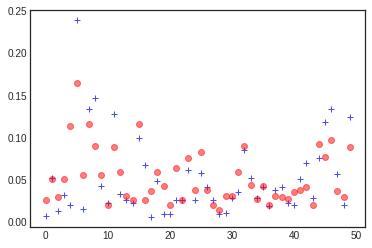

In [65]:
#Lets plot the  first 50 predictions
plt.plot(y_test.as_matrix()[0:50], '+', color ='blue', alpha=0.7)
plt.plot(y_pred[0:50], 'ro', color ='red', alpha=0.5)
plt.show()

## ExtraTrees Regressor
Extra-trees differ from classic decision trees in the way they are built. When looking for the best split to separate the samples of a node into two groups, random splits are drawn for each of the max_features randomly selected features and the best split among those is chosen.

In [66]:

etr = ExtraTreesRegressor()

# Choose some parameter combinations to try

parameters = {'n_estimators': [5,10,100],
              'criterion': ['mse'],
              'max_depth': [5,10,15], 
              'min_samples_split': [2,5,10],
              'min_samples_leaf': [1,5]
             }
#We have to use RandomForestRegressor's own scorer (which is R^2 score)

#Determines the cross-validation splitting strategy /to specify the number of folds in a (Stratified)KFold

grid_obj = GridSearchCV(etr, parameters,
                        cv=3, 
                        n_jobs=-1, #Number of jobs to run in parallel
                        verbose=1)
grid_obj = grid_obj.fit(X_train, y_train)

# Set the clf to the best combination of parameters
etr = grid_obj.best_estimator_

# Fit the best algorithm to the data. 
etr.fit(X_train, y_train)

Fitting 3 folds for each of 54 candidates, totalling 162 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:   41.2s
[Parallel(n_jobs=-1)]: Done 162 out of 162 | elapsed:  5.5min finished


ExtraTreesRegressor(bootstrap=False, criterion='mse', max_depth=15,
                    max_features='auto', max_leaf_nodes=None,
                    min_impurity_decrease=0.0, min_impurity_split=None,
                    min_samples_leaf=1, min_samples_split=10,
                    min_weight_fraction_leaf=0.0, n_estimators=100, n_jobs=None,
                    oob_score=False, random_state=None, verbose=0,
                    warm_start=False)

In [67]:
import math
y_pred = etr.predict(X_test)

print('R2 score = ',r2_score(y_test, y_pred), '/ 1.0')
print('MSE score = ',mean_squared_error(y_test, y_pred), '/ 0.0')
print('RMSE score = ',math.sqrt(mean_squared_error(y_test, y_pred)), '/ 0.0')

R2 score =  0.7002745681507502 / 1.0
MSE score =  0.00100293910498794 / 0.0
RMSE score =  0.031669213835962835 / 0.0


/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:2: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  


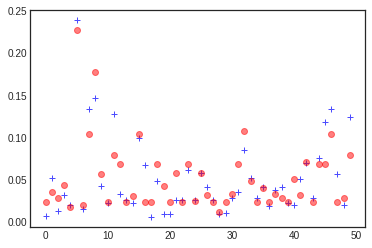

In [68]:
#Lets plot the  first 50 predictions
plt.plot(y_test.as_matrix()[0:50], '+', color ='blue', alpha=0.7)
plt.plot(y_pred[0:50], 'ro', color ='red', alpha=0.5)
plt.show()

# Random Forest Regressor

In [69]:
# Choose the type of classifier. 
RFR = RandomForestRegressor()

# Choose some parameter combinations to try
parameters = {'n_estimators': [5, 10, 100],
              'min_samples_leaf': [1,5]
             }


#We have to use RandomForestRegressor's own scorer (which is R^2 score)

#Determines the cross-validation splitting strategy /to specify the number of folds in a (Stratified)KFold
grid_obj = GridSearchCV(RFR, parameters,
                        cv=5, 
                        n_jobs=-1, #Number of jobs to run in parallel
                        verbose=1)
grid_obj = grid_obj.fit(X_train, y_train)

# Set the clf to the best combination of parameters
RFR = grid_obj.best_estimator_

# Fit the best algorithm to the data. 
RFR.fit(X_train, y_train)

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.


Fitting 5 folds for each of 6 candidates, totalling 30 fits


[Parallel(n_jobs=-1)]: Done  30 out of  30 | elapsed:  2.1min finished


RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
                      max_features='auto', max_leaf_nodes=None,
                      min_impurity_decrease=0.0, min_impurity_split=None,
                      min_samples_leaf=1, min_samples_split=2,
                      min_weight_fraction_leaf=0.0, n_estimators=100,
                      n_jobs=None, oob_score=False, random_state=None,
                      verbose=0, warm_start=False)

In [70]:
y_pred = RFR.predict(X_test)

print('R2 score = ',r2_score(y_test, y_pred), '/ 1.0')
print('MSE score = ',mean_squared_error(y_test, y_pred), '/ 0.0')
print('RMSE score = ',math.sqrt(mean_squared_error(y_test, y_pred)), '/ 0.0')

R2 score =  0.8017773176812173 / 1.0
MSE score =  0.000663291327554413 / 0.0
RMSE score =  0.025754442870200338 / 0.0


/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:2: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  


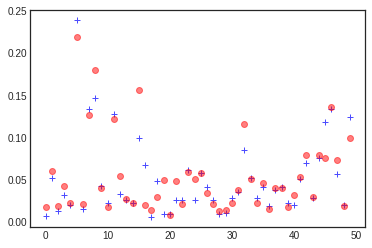

In [71]:
#Lets plot the  first 50 predictions
plt.plot(y_test.as_matrix()[0:50], '+', color ='blue', alpha=0.7)
plt.plot(y_pred[0:50], 'ro', color ='red', alpha=0.5)
plt.show()

### Even after tuning the parameters multiple times above is the best RMSE score obtained through RandomForest Regressor
Below is an example.

In [72]:
RFR = RandomForestRegressor()

# Choose some parameter combinations to try
parameters = {'n_estimators': [5,10,500],
               'max_features':['auto'],
              'min_samples_leaf': [1,5,10,50]
             }


#We have to use RandomForestRegressor's own scorer (which is R^2 score)

#Determines the cross-validation splitting strategy /to specify the number of folds in a (Stratified)KFold
grid_obj = GridSearchCV(RFR, parameters,
                        cv=5, 
                        n_jobs=-1, #Number of jobs to run in parallel
                        verbose=1)
grid_obj = grid_obj.fit(X_train, y_train)

# Set the clf to the best combination of parameters
RFR = grid_obj.best_estimator_

# Fit the best algorithm to the data. 
RFR.fit(X_train, y_train)

Fitting 5 folds for each of 12 candidates, totalling 60 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed: 10.9min
[Parallel(n_jobs=-1)]: Done  60 out of  60 | elapsed: 16.0min finished


RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
                      max_features='auto', max_leaf_nodes=None,
                      min_impurity_decrease=0.0, min_impurity_split=None,
                      min_samples_leaf=1, min_samples_split=2,
                      min_weight_fraction_leaf=0.0, n_estimators=500,
                      n_jobs=None, oob_score=False, random_state=None,
                      verbose=0, warm_start=False)

In [73]:
y_pred = RFR.predict(X_test)

print('R2 score = ',r2_score(y_test, y_pred), '/ 1.0')
print('RMSE score = ',math.sqrt(mean_squared_error(y_test, y_pred)), '/ 0.0')

R2 score =  0.806252980195732 / 1.0
RMSE score =  0.0254620285431131 / 0.0


/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:2: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  


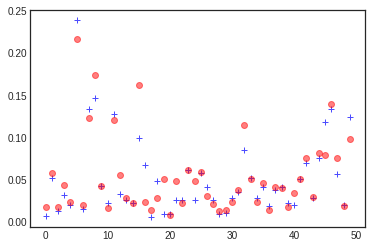

In [74]:
#Lets plot the  first 50 predictions
plt.plot(y_test.as_matrix()[0:50], '+', color ='blue', alpha=0.7)
plt.plot(y_pred[0:50], 'ro', color ='red', alpha=0.5)
plt.show()

# Gradient Boosting Regressor

In [75]:
#gbr = GradientBoostingRegressor(loss='huber',learning_rate=0.3,n_estimators=100,max_depth=5,min_samples_split=3)
gbr=GradientBoostingRegressor()

parameters = {'n_estimators': [5,10],
              'loss':['huber'],
              'criterion': ['mse'],
              'max_depth': [5,10], 
              'min_samples_split': [2,5],
              'min_samples_leaf': [1,5]
             }

#Determines the cross-validation splitting strategy /to specify the number of folds in a (Stratified)KFold
grid_obj = GridSearchCV(gbr, parameters,
                        cv=5, 
                        n_jobs=-1, #Number of jobs to run in parallel
                        verbose=1)
grid_obj = grid_obj.fit(X_train, y_train)

# Set the clf to the best combination of parameters
gbr = grid_obj.best_estimator_

# Fit the best algorithm to the data. 
gbr.fit(X_train, y_train)

Fitting 5 folds for each of 16 candidates, totalling 80 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:   34.0s
[Parallel(n_jobs=-1)]: Done  80 out of  80 | elapsed:  1.9min finished


GradientBoostingRegressor(alpha=0.9, criterion='mse', init=None,
                          learning_rate=0.1, loss='huber', max_depth=10,
                          max_features=None, max_leaf_nodes=None,
                          min_impurity_decrease=0.0, min_impurity_split=None,
                          min_samples_leaf=1, min_samples_split=2,
                          min_weight_fraction_leaf=0.0, n_estimators=10,
                          n_iter_no_change=None, presort='auto',
                          random_state=None, subsample=1.0, tol=0.0001,
                          validation_fraction=0.1, verbose=0, warm_start=False)

In [76]:
y_pred = gbr.predict(X_test)

print('R2 score using Gradient Boosting= ',r2_score(y_test, y_pred), '/ 1.0')
print('RMSE score using XG Boost= ',math.sqrt(mean_squared_error(y_test, y_pred)), '/ 0.0')

R2 score using Gradient Boosting=  0.4739730931776369 / 1.0
RMSE score using XG Boost=  0.04195458840824953 / 0.0


/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:1: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  """Entry point for launching an IPython kernel.


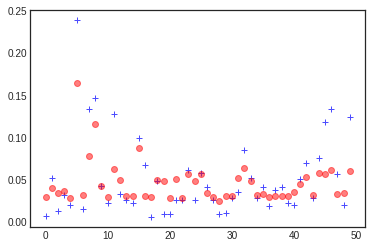

In [77]:
plt.plot(y_test.as_matrix()[0:50], '+', color ='blue', alpha=0.7)
plt.plot(y_pred[0:50], 'ro', color ='red', alpha=0.5)
plt.show()

In [78]:
gbr = GradientBoostingRegressor(loss='ls',learning_rate=0.1,n_estimators=150,max_depth=10,min_samples_split=5)


parameters = {'n_estimators': [5,15,150],
              'loss':['ls','huber'],
              'criterion': ['mse'],
              'max_depth': [10,15], 
              'min_samples_split': [2,5],
              'min_samples_leaf': [1,5]
             }

#Determines the cross-validation splitting strategy /to specify the number of folds in a (Stratified)KFold
grid_obj = GridSearchCV(gbr, parameters,
                        cv=5, 
                        n_jobs=-1, #Number of jobs to run in parallel
                        verbose=1)
grid_obj = grid_obj.fit(X_train, y_train)

# Set the clf to the best combination of parameters
gbr = grid_obj.best_estimator_

# Fit the best algorithm to the data. 
gbr.fit(X_train, y_train)

Fitting 5 folds for each of 48 candidates, totalling 240 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:  8.6min
[Parallel(n_jobs=-1)]: Done 192 tasks      | elapsed: 60.3min
[Parallel(n_jobs=-1)]: Done 240 out of 240 | elapsed: 85.0min finished


GradientBoostingRegressor(alpha=0.9, criterion='mse', init=None,
                          learning_rate=0.1, loss='huber', max_depth=15,
                          max_features=None, max_leaf_nodes=None,
                          min_impurity_decrease=0.0, min_impurity_split=None,
                          min_samples_leaf=5, min_samples_split=5,
                          min_weight_fraction_leaf=0.0, n_estimators=150,
                          n_iter_no_change=None, presort='auto',
                          random_state=None, subsample=1.0, tol=0.0001,
                          validation_fraction=0.1, verbose=0, warm_start=False)

In [79]:
y_pred = RFR.predict(X_test)

print('R2 score using Gradient Boosting= ',r2_score(y_test, y_pred), '/ 1.0')
print('RMSE score using Gradient Boosting= ',math.sqrt(mean_squared_error(y_test, y_pred)), '/ 0.0')

R2 score using Gradient Boosting=  0.806252980195732 / 1.0
RMSE score using Gradient Boosting=  0.0254620285431131 / 0.0


/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:1: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  """Entry point for launching an IPython kernel.


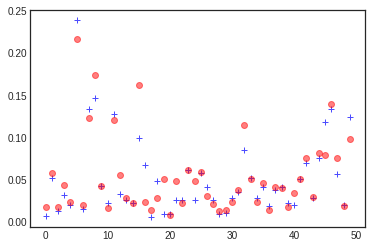

In [80]:
plt.plot(y_test.as_matrix()[0:50], '+', color ='blue', alpha=0.7)
plt.plot(y_pred[0:50], 'ro', color ='red', alpha=0.5)
plt.show()

# XGBoost Regressor

In [81]:
model=XGBRegressor(max_depth=10)

In [82]:
model.fit(X_train,y_train)

/opt/conda/lib/python3.6/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[01:13:13] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=1, gamma=0,
             importance_type='gain', learning_rate=0.1, max_delta_step=0,
             max_depth=10, min_child_weight=1, missing=None, n_estimators=100,
             n_jobs=1, nthread=None, objective='reg:linear', random_state=0,
             reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
             silent=None, subsample=1, verbosity=1)

In [83]:
y_pred=model.predict(X_test)

In [84]:
import math
print('R2 score using XG Boost= ',r2_score(y_test, y_pred), '/ 1.0')
print('RMSE score using XG Boost= ',math.sqrt(mean_squared_error(y_test, y_pred)), '/ 0.0')

R2 score using XG Boost=  0.8123605819466322 / 1.0
RMSE score using XG Boost=  0.02505748758471952 / 0.0


/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:1: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  """Entry point for launching an IPython kernel.


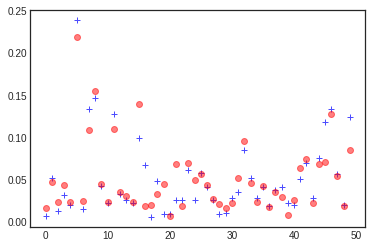

In [85]:
plt.plot(y_test.as_matrix()[0:50], '+', color ='blue', alpha=0.7)
plt.plot(y_pred[0:50], 'ro', color ='red', alpha=0.5)
plt.show()

In [ ]:
#PREDICTED RESULTS OF TESTING DATA
y_true = []
for val in y_pred:
    val = (val * (max_train-min_train) + min_train)
    y_true.append(val)
y_true

In [ ]:
#TRUE RESULTS OF TESTING DATA
y_test_true = []
for val in y_test:
    val = (val * (max_train-min_train) + min_train)
    y_test_true.append(val)
y_test_true